In [31]:
import ast
import copy
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import open3d.cpu.pybind as o3d
import matplotlib.pyplot as plt
from typing import List, Tuple
from pathlib import Path
from dataclasses import dataclass

In [35]:
@dataclass 
class Odometry:
    loc: Tuple[float, float] # (x, y)
    angle: float # radians

def fetch_point_clouds(scans: np.array):
    pcds = []
    prev_elevation = 0
    for scan in scans:
        mask = np.linalg.norm(scan, axis=1) < 20
            
        P_s = np.array(scan)[mask]
        arr_s = np.zeros((P_s.shape[0], 3))
        arr_s[:, :2] = P_s
        arr_s[:, 2] = prev_elevation
        prev_elevation += 0.01
        # print(arr_s.shape)
        pc = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(arr_s))
        pc.estimate_normals()
        pcds.append(pc)

    return pcds


def pairwise_registration(source: o3d.geometry.PointCloud, 
                          target: o3d.geometry.PointCloud, 
                          max_correspondence_distance_coarse: float, 
                          max_correspondence_distance_fine: float,
                          criteria: o3d.pipelines.registration.ICPConvergenceCriteria):
    icp_coarse = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_coarse, np.identity(4),
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    
    icp_fine = o3d.pipelines.registration.registration_icp(
        source, target, max_correspondence_distance_fine,
        icp_coarse.transformation,
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        criteria)
    
    transformation_icp = icp_fine.transformation
    information_icp = o3d.pipelines.registration.get_information_matrix_from_point_clouds(
        source, target, max_correspondence_distance_fine,
        icp_fine.transformation)
    return transformation_icp, information_icp, icp_fine.fitness, icp_fine.inlier_rmse

def generate_pose_graph(pcds, max_correspondence_distance_coarse,
                      max_correspondence_distance_fine, criteria):
    pose_graph = o3d.pipelines.registration.PoseGraph()
    odometry = np.identity(4)
    pose_graph.nodes.append(o3d.pipelines.registration.PoseGraphNode(odometry))
    n_pcds = len(pcds)

    icp_metrics = {'fitness': [], 'inlier_rmse': []}

    for source_id in tqdm(range(n_pcds)):
        for target_id in range(source_id + 1, n_pcds):
            if target_id != source_id + 1:
                continue
            transformation_icp, information_icp, fitness, inlier_rmse = pairwise_registration(
                pcds[source_id], pcds[target_id], 
                max_correspondence_distance_coarse, max_correspondence_distance_fine, criteria)
            
            # print(transformation_icp)
            
            icp_metrics['fitness'].append(fitness)
            icp_metrics['inlier_rmse'].append(inlier_rmse)

            if target_id == source_id + 1:  # odometry case 
                odometry = np.dot(transformation_icp, odometry)
                pose_graph.nodes.append(
                    o3d.pipelines.registration.PoseGraphNode(
                        np.linalg.inv(odometry)))
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=False))
            else:  # loop closure case
                pose_graph.edges.append(
                    o3d.pipelines.registration.PoseGraphEdge(source_id,
                                                             target_id,
                                                             transformation_icp,
                                                             information_icp,
                                                             uncertain=True))
    return pose_graph, pd.DataFrame(icp_metrics)


def optimize_pose_graph(pose_graph, max_correspondence_distance_fine):
    option = o3d.pipelines.registration.GlobalOptimizationOption(
    max_correspondence_distance=max_correspondence_distance_fine,
    edge_prune_threshold=0.25,
    reference_node=0)
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        o3d.pipelines.registration.global_optimization(
            pose_graph,
            o3d.pipelines.registration.GlobalOptimizationLevenbergMarquardt(),
            o3d.pipelines.registration.GlobalOptimizationConvergenceCriteria(),
            option)
    return pose_graph


def draw_robot(odom: Odometry, color: str = 'black'):
      plt.scatter(*odom.loc, c=color, marker="s", s=30)
      s1 = math.tan(odom.angle)
      x = np.array([odom.loc[0], odom.loc[0] + 0.25 * math.cos(odom.angle)])
      y = np.array([odom.loc[1], odom.loc[1] + 0.25 * math.sin(odom.angle)])
      plt.plot(x, y, c="blue")


def generate_map_plot(pcds, odometry, pose_graph, name):
    plt.clf()
    optimized_poses = copy.deepcopy(pcds)
    start_loc = None
    end_loc = None

    for point_id in range(len(pcds)):
        optimized_poses[point_id].transform(pose_graph.nodes[point_id].pose)
        
        loc = np.dot(pose_graph.nodes[point_id].pose, [*odometry[point_id][:2], 1, 1])[:2]
        
        if point_id == 0:
          start_loc = loc
        if point_id == len(pcds) - 1:
          end_loc = loc

        theta_z = np.arctan2(pose_graph.nodes[point_id].pose[1, 0], 
                             pose_graph.nodes[point_id].pose[0, 0])

        theta = odometry[point_id][2] + theta_z

        color = 'black'
        if point_id == 0:
            color = 'green'
        if point_id == len(pcds) - 1:
            color = 'red'
        draw_robot(Odometry(loc=tuple(loc), angle=theta), color=color)

    pc_map = o3d.geometry.PointCloud()
    for pose in optimized_poses:
        pc_map += pose

    pc_map_down = pc_map.voxel_down_sample(voxel_size=voxel_size)
    # print(f'Relative Transformation: {end_loc - start_loc}')

    points = np.asarray(pc_map_down.points)
    plt.scatter(*points.T[:2], c='r', s=0.1)
    plt.axis('equal')
    plt.show()
    # plt.savefig(name)
    # plt.clf()

In [14]:
scans = pd.read_csv('scan.csv', header=None, delimiter=' ').iloc[:, :-1]
def convert_to_xy(point_str):
    x, y = ast.literal_eval(point_str)
    return [x, y]
scans = scans.applymap(convert_to_xy)
scans = np.array(scans.values.tolist())

with open("optimized_poses.csv", 'r') as file:
    lines = file.readlines()
data = [line.strip('()\n').split(', ') for line in lines]
pose_graph = np.array(data, dtype=float)

odometry = np.loadtxt("location.csv", delimiter=",")

In [ ]:
voxel_size = 0.02
max_correspondence_distance_coarse = voxel_size * 15
max_correspondence_distance_fine = voxel_size * 1.5
criteria = o3d.pipelines.registration.ICPConvergenceCriteria()

pcds = fetch_point_clouds(scans)
pose_graph, metrics = generate_pose_graph(pcds, max_correspondence_distance_coarse, max_correspondence_distance_fine, criteria)
pose_graph = optimize_pose_graph(pose_graph, max_correspondence_distance_fine)
generate_map_plot(pcds, odometry, pose_graph, f'test-map.png')

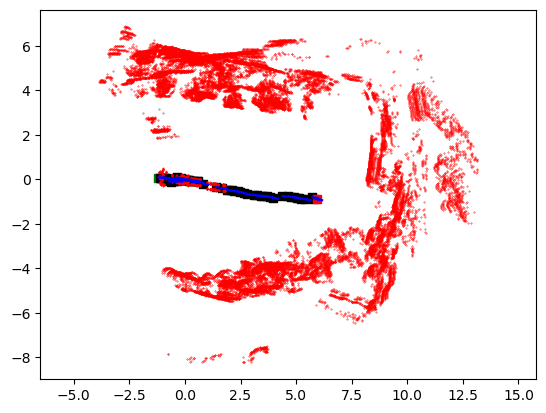

In [36]:
generate_map_plot(pcds, odometry, pose_graph, f'test-map.png')